In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, max_error, mean_absolute_percentage_error
from scipy.stats import kurtosis, skew
import shap

In [3]:
train = pd.read_csv('../input/LANL-Earthquake-Prediction/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})
pd.options.display.precision = 15
train.head()

,acoustic_data,time_to_failure
0,12,1.4690999832
1,6,1.4690999821
2,8,1.4690999810
3,5,1.4690999799
4,8,1.4690999788


The dataset in input is divided in segments of 150 000 samples each (as is divided the test set for the challange), it generates 4194 segments

In [4]:
rows = 150_000
segments = int(np.floor(train.shape[0] / rows))

X_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['ave','std','max','min','skew','kurtosis'])
y_train = pd.DataFrame(index=range(segments), dtype=np.float64, columns=['time_to_failure'])

for segment in range(segments):
    seg = train.iloc[segment*rows:segment*rows+rows]
    x = seg['acoustic_data'].values
    y = seg['time_to_failure'].values[-1]
    y_train.loc[segment, 'time_to_failure'] = y
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'skew'] = skew(x)
    X_train.loc[segment, 'kurtosis'] = kurtosis(x)    

In [5]:
X_train.head()

,ave,std,max,min,skew,kurtosis
0,4.884113333333334,5.101089126891323,104.0,-98.0,-0.024060926015874,33.661319221480703
1,4.725766666666667,6.588801819164257,181.0,-154.0,0.390556598755942,98.755185259155695
2,4.906393333333333,6.967373808828945,140.0,-106.0,0.217388387534031,33.554052910588105
3,4.902240000000000,6.922282112791032,197.0,-199.0,0.757269963614698,116.544246785098039
4,4.908720000000000,7.301085852684289,145.0,-126.0,0.064530423958889,52.976098920993913


Then normalize the training data

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
y_train_flatten = y_train.values.flatten()

In [7]:
def plot(y_train_flatten, y_pred):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_train_flatten, y_pred)
    plt.xlim(0, 20)
    plt.ylim(0, 20)
    plt.xlabel('actual', fontsize=12)
    plt.ylabel('predicted', fontsize=12)
    plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])
    plt.show()

In [8]:
def score(y_train_flatten, y_pred):
    max = max_error(y_train_flatten, y_pred)
    mae = mean_absolute_error(y_train_flatten, y_pred)
    mape = mean_absolute_percentage_error(y_train_flatten, y_pred)
    print(f'Max Error: {max:0.3f}')
    print(f'Mean Absolute Error: {mae:0.3f}')
    print(f'Mean Absolute Percentage Error: {mape:0.3f}')    

# Catboost with Root Mean Square Error

In [9]:
m_rmse = CatBoostRegressor()
m_rmse.fit(X_train_scaled, y_train.values.flatten(), silent=True)
y_pred_m_rmse = m_rmse.predict(X_train_scaled)

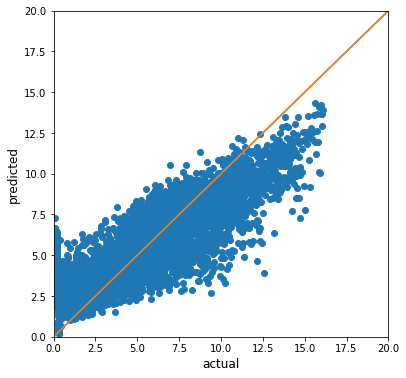

In [10]:
plot(y_train_flatten, y_pred_m_rmse)

In [11]:
score(y_train_flatten, y_pred_m_rmse)

Max Error: 8.649
Mean Absolute Error: 1.596
Mean Absolute Percentage Error: 2.536


## Interpretation of the model

In [12]:
explainer = shap.Explainer(m_rmse)
shap_values = explainer(X_train)

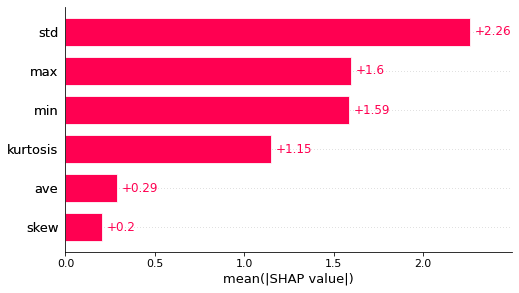

In [13]:
shap.plots.bar(shap_values)

The plot above shows the **importance** of the feature in the feature in scoring a segment.

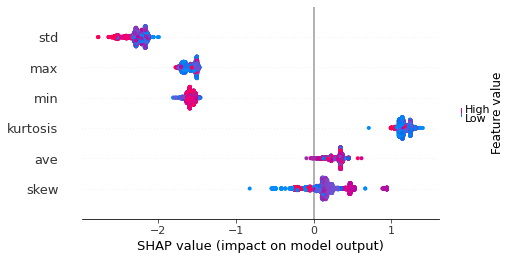

In [14]:
shap.plots.beeswarm(shap_values)

The plot above shows how the calculated features in the dataset impact the model’s output.
The blue points are associated with low values, the red ones with high values.

In [15]:
shap.initjs()
shap.plots.force(shap_values[1651])

The graph above shows how the different features impact the score calculated for the segment 1651. The mangitude of the arrows corresponds to the weight of the features shown in the first graph of this section.

# Submission of the model

In [16]:
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')

In [17]:
X_test = pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [18]:
for segment_id in X_test.index:
    filename = "../input/LANL-Earthquake-Prediction/test/{0}.csv".format(segment_id)
    segment =  pd.read_csv(filename)
    x = segment['acoustic_data'].values
    X_test.loc[segment_id, 'ave'] = x.mean()
    X_test.loc[segment_id, 'std'] = x.std()
    X_test.loc[segment_id, 'max'] = x.max()
    X_test.loc[segment_id, 'min'] = x.min()
    X_test.loc[segment_id, 'skew'] = skew(x)
    X_test.loc[segment_id, 'kurtosis'] = kurtosis(x)    

In [19]:
X_test_scaled = scaler.transform(X_test)
submission['time_to_failure'] = m_rmse.predict(X_test_scaled)
submission.to_csv('submission.csv')